# Load data
We load the data from **data.csv** (extracted from **data_carbs.xlsx**), and divide the data by the type of activity.
* There are six types of activties in data.csv
* We print out the energy type after we load the data.

In [39]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

%matplotlib inline

with open('data.csv', newline='') as csvfile:
    trainingdata = csv.reader(csvfile, delimiter=',')
    copydata=[]
    Act={1:[],2:[],3:[],4:[],5:[],6:[]}
    i,Eneg,Col=0,[],[]

    for row in trainingdata:
        if i>0:
            copydata.append(row)
        if i==0:
            Col=row
            Eneg=row[6:]
            print(Col)
            
        if 0<i<28:
            Act[int(row[1])].append(row[2])    
        i = i+1

['Indnum', 'Group', 'Activity', 'Units', 'Consumption', 'Quality_of_Life_Importance__1_10', 'solar_powered__water_heater', 'gas_water_heater', 'electric_water_heater___peak_hours', 'electric_water_heater___off_peak hours', 'gas', 'natural_gas', 'hybrid', 'electric___peak_hours', 'electric___off_peak_hours', 'Jet Fuel']


# Load Carbon Map
We have following lists:
* **acts**: the activities
* **cols**: the energy resource
* **carb_map**: the carbon footprint of the activities from each energy type


In [40]:
carb_map,acts,cols=[],[],[]

with open('carbMap.csv', newline='') as csvfile: 
    carbdata = csv.reader(csvfile, delimiter=',')
    i=0
    for row in carbdata:
        if i==0:
            cols=[clear_text(x) for x in row]
        else:
            carb_map.append(row)
            acts.append(row[0])
        i+=1
print(cols)
print(acts)
#carb_map=np.asarray(carb_map)
#print(np.argmax([max(x[2:]) for x in carb_map]))
#print (carb_map[22][0])            

['Activity', 'Per', 'solar powered  water heater', 'gas water heater', 'electric water heater peak hours', 'electric water heater off peak hours', 'gas', 'natural gas', 'Jet Fuel', 'waste management', 'hybrid', 'electric peak hours', 'electric off peak hours']
['Household heating => 70F', 'Household heating < 70F', 'Use of heat pump', 'Use of air conditioner', 'shower - short', 'shower - long (> 3 min)', 'bath', 'wash-up', 'use of dishwasher', 'use of clothes washer', 'use of clothes dryer', 'use of cooking range', 'use of  oven', 'use of self-clean feature of electric oven', 'Small kitchen appliance in the home', 'TV/computer use', 'air travel - large plane', 'air travel - small  plane (<50 seats)', 'car trips- self only', 'car trips - driver and self', 'car trips - 2+ people with multiple end points', 'trips using public ground transportation', 'bags of garbage disposed', 'bags of recycling deposited (negative CF)', 'bags of compost deposited (negative CF)', 'hazardous or electric it

# Features for each Individual
For each individual, we compute:
* **importance**: the importance they value on each activity
* **unit**: the time units spend on each activity
* **carbs**: the carbon footprints for each activity
* **carb**: the total carbon footprints they produce daily

In the end of cell below, we plot the carbons produced by 1000 the users in an increasing order.

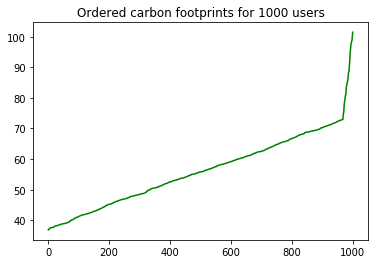

In [44]:
newdata,importance,units,carbs,carb=[],[],[],[],0
for i,row in enumerate(copydata):
    if i%27== 0:
        newdata.append([importance,units,carbs,carb])
        
        importance=[]
        units=[]
        carbs=[]
        carb=0
    
    importance.append(to_int(row[5]))
    units.append(to_int(row[4]))
    act,eneg,unit=row[2],Eneg[np.argmax(row[6:])],to_int(row[4])
    carbs.append(carb_cnt(act,eneg,unit))
    carb=sum(carbs)
users=np.asarray(newdata[1:])


carb_plot(users[:,3],'Ordered carbon footprints for 1000 users')

norm_users=norm_units(users)


# Recommendation for Users
1. **get_neights**: Get the *k* neighbors for each indiviual. We use nearest neighbors algorithm to find the neighbors indices.
    * I_indice: with near values on activities 
    * U_indice: spend near time units
    * IU_indeice: both of above
2. **get_recommend**: We compute the recommedation for each indiviaul with the given neighbors indices. We can also use diffirent functions to evalutate the happiness. We find the neighbos who produce the least carbons and suggest the individual refer the time unit the neighbor spend and recount the carbon usage and happiness after the suggestion.
3. **performance**: Return the total happiness and carbon usage after recommendation
4. **new_life_plot**: Plot the new life after recommendation. We plot happiness and canborn usage compared to oringal life in percentage.
5. **report**: Given k neighbors and function of evaluating the happiness, we report and plot the happiness and carbon usage after recoomendation.

In [ ]:
from sklearn.neighbors import NearestNeighbors
def get_neighs(k,indiv):

    Impor = [row[0] for row in indiv]
    Unit =  [row[1] for row in indiv]
    Impor_Unit = [row[0]+row[1] for row in indiv]

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Impor[:])
    distances, I_indice = nbrs.kneighbors(Impor[:])
    #matric = nbrs.kneighbors_graph(X).toarray()

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Unit[:])
    distances, U_indice = nbrs.kneighbors(Unit[:])
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Impor_Unit[:])
    distances, IU_indice = nbrs.kneighbors(Impor_Unit[:])
    return I_indice,U_indice,IU_indice




In [ ]:
#pick for the neighbors which spend least carbons    
def get_recommend(indice,indiv,fuc):
    recommend=[]
    
    for i,person in enumerate(indice):
        candidates= np.asarray([indiv[neigh] for neigh in person])
        
        carb=indiv[i][3]
        cand=np.argmin(candidates[:,3])
        cand_carb=candidates[cand][3]
        reduce=cand_carb/carb
        
        I,U=indiv[i][:2]
        cand_I,cand_U=candidates[cand][:2]
        adjusted_I=adjust_I(I,cand_I)
        
        happy,new_happy=Happy(I,fuc,U,i),Happy(adjusted_I,fuc,cand_U,i)
        loss=new_happy/happy
        recommend.append([i,cand,carb,cand_carb,reduce,loss])
        
    recommend=np.asarray(recommend)
    #print(recommend[:5])
    return recommend

In [ ]:
def performance(recom):
    happiness=sum(recom[:,-1])/len(recom)
    carb_utage=sum(recom[:,-2])/len(recom)
    print('happiness: {percent:.2%}'.format(percent=happiness),
          'carb utage: {percent:.2%}'.format(percent=carb_utage))


In [51]:
from collections import Counter,OrderedDict
def new_life_plot(recom):
    plt.rcParams['figure.figsize'] = [8, 4]
    happy=recom[:,-1]
    happiness= [int(100*x) for x in happy]
    
    h=Counter((x) for x in happiness)
    h=OrderedDict(sorted(h.items()))
    plt.plot(h.keys(),h.values())
    
    carb=recom[:,-2]
    carbon= [int(100*x) for x in carb]
    
    c=Counter((x) for x in carbon)
    c=OrderedDict(sorted(c.items()))
    plt.plot(c.keys(),c.values(),'c',10)
    plt.show()

In [55]:
def report(k,fuc):
    for i,indice in enumerate(get_neighs(k,norm_users)):
        
        recom=get_recommend(indice,norm_users,fuc)
        performance(recom)
        
        if i==0 :new_life_plot(recom) #report the recomender generated by importance_
            
    print('----Evaluate utility by',fuc,'\n',
      '(Recommend behavior adjustion from',k,'neighbors using features\n'
      'Importance, Units, Importance_and_Units, respectively)\n')



# Results
We use nearest k neighbors to help us recomend new life to users. We find the best sample for each individula from their 10, 20, 50 , and 100 neighbors. 

* Note that we think the happiness is linear proportional to how they value the activities they do. But it may be non-linear proportional to the units they spend because the margin effect theory. So we try different functions linear, softmax, log, root, or tanh as the relation between units and happiness.

We find the neighors according to the near value on activites, or near same units spend on the activites, or both above. In the result, we find that
          
* If we make recommendation from the individaul who has the near value on activities can reduce the carbon usage the most. 
* Averagely, the more neighbors we consider, the better performance both in happiness and carbon usage.
* Find neighbors with near value contribute a lot on carbon usage reduction but in the view of happiness, the porformance is not as well as find neighbors from near time consumptions.
* The graph shows that the new life for all users who got the recommendation from the neighbors who has the near value on the activities. The dark blue line is the new happiness compared to origin in percentage (sorted), and the light blue is the new carbon usage compared to origin in percentage (sorted).

happiness: 98.88% carb utage: 76.03%


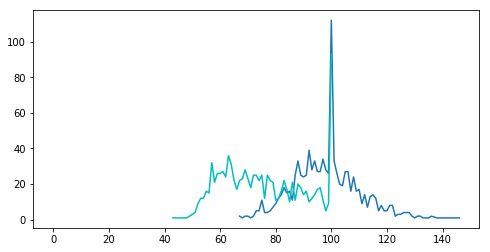

happiness: 98.07% carb utage: 76.51%
happiness: 99.03% carb utage: 76.08%
----Evaluate utility by linear 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.92% carb utage: 76.03%


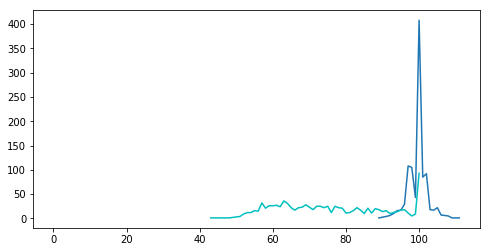

happiness: 99.57% carb utage: 76.51%
happiness: 99.95% carb utage: 76.08%
----Evaluate utility by softmax 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.04% carb utage: 76.03%


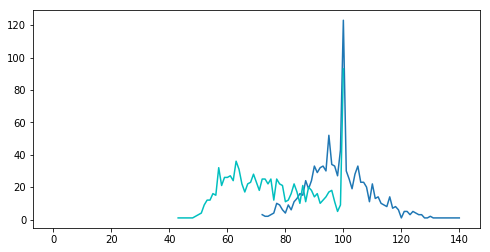

happiness: 98.55% carb utage: 76.51%
happiness: 99.16% carb utage: 76.08%
----Evaluate utility by log 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.26% carb utage: 76.03%


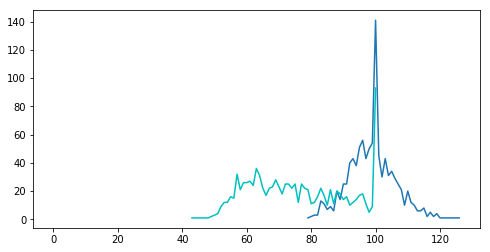

happiness: 98.93% carb utage: 76.51%
happiness: 99.35% carb utage: 76.08%
----Evaluate utility by root 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.07% carb utage: 76.03%


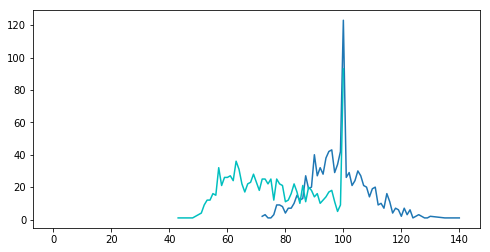

happiness: 98.73% carb utage: 76.51%
happiness: 99.19% carb utage: 76.08%
----Evaluate utility by tanh 
 (Recommend behavior adjustion from 10 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 98.90% carb utage: 72.91%


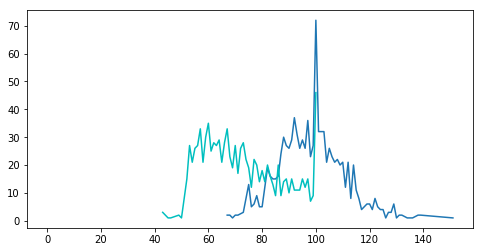

happiness: 97.61% carb utage: 72.94%
happiness: 98.85% carb utage: 73.00%
----Evaluate utility by linear 
 (Recommend behavior adjustion from 20 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 100.13% carb utage: 72.91%


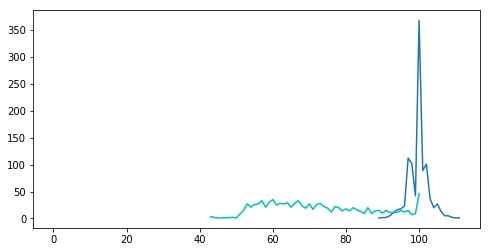

happiness: 99.52% carb utage: 72.94%
happiness: 100.14% carb utage: 73.00%
----Evaluate utility by softmax 
 (Recommend behavior adjustion from 20 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.10% carb utage: 72.91%


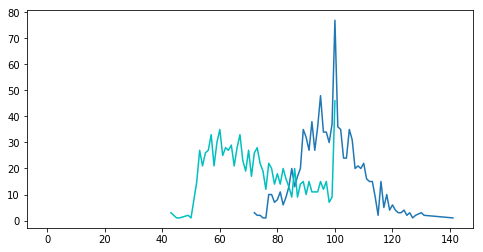

happiness: 98.18% carb utage: 72.94%
happiness: 99.06% carb utage: 73.00%
----Evaluate utility by log 
 (Recommend behavior adjustion from 20 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.38% carb utage: 72.91%


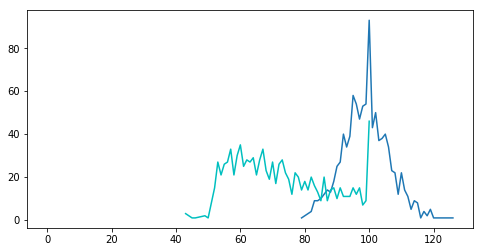

happiness: 98.67% carb utage: 72.94%
happiness: 99.35% carb utage: 73.00%
----Evaluate utility by root 
 (Recommend behavior adjustion from 20 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.14% carb utage: 72.91%


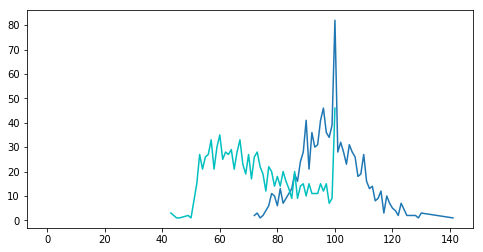

happiness: 98.38% carb utage: 72.94%
happiness: 99.09% carb utage: 73.00%
----Evaluate utility by tanh 
 (Recommend behavior adjustion from 20 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 98.94% carb utage: 70.14%


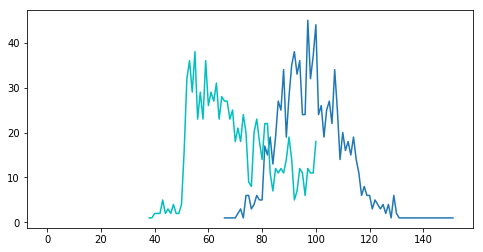

happiness: 97.76% carb utage: 70.44%
happiness: 98.98% carb utage: 70.21%
----Evaluate utility by linear 
 (Recommend behavior adjustion from 50 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 100.37% carb utage: 70.14%


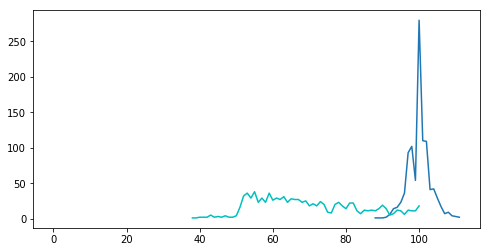

happiness: 99.69% carb utage: 70.44%
happiness: 100.36% carb utage: 70.21%
----Evaluate utility by softmax 
 (Recommend behavior adjustion from 50 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.29% carb utage: 70.14%


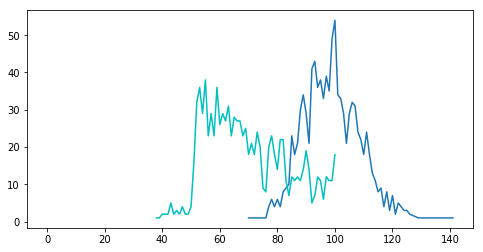

happiness: 98.29% carb utage: 70.44%
happiness: 99.32% carb utage: 70.21%
----Evaluate utility by log 
 (Recommend behavior adjustion from 50 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.64% carb utage: 70.14%


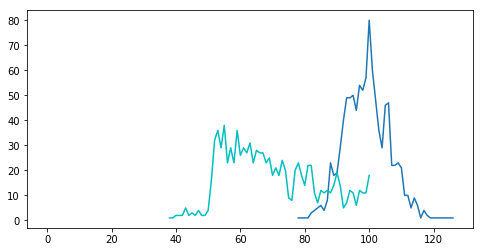

happiness: 98.79% carb utage: 70.44%
happiness: 99.65% carb utage: 70.21%
----Evaluate utility by root 
 (Recommend behavior adjustion from 50 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.38% carb utage: 70.14%


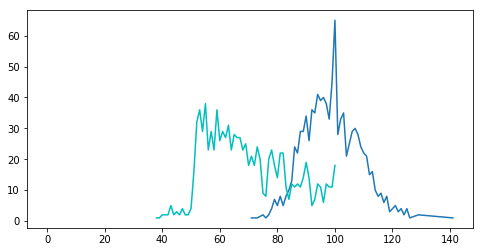

happiness: 98.47% carb utage: 70.44%
happiness: 99.41% carb utage: 70.21%
----Evaluate utility by tanh 
 (Recommend behavior adjustion from 50 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 98.47% carb utage: 69.43%


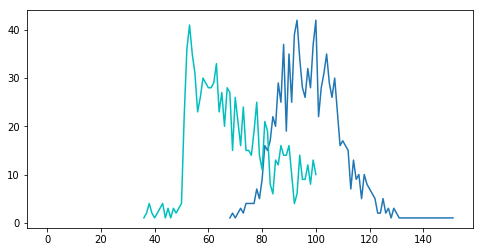

happiness: 97.62% carb utage: 69.53%
happiness: 98.56% carb utage: 69.45%
----Evaluate utility by linear 
 (Recommend behavior adjustion from 100 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 100.47% carb utage: 69.43%


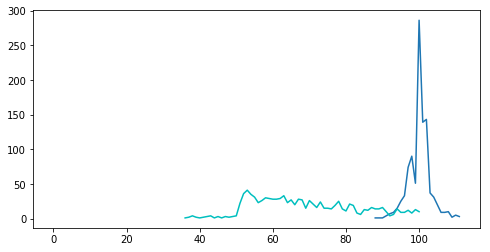

happiness: 99.71% carb utage: 69.53%
happiness: 100.43% carb utage: 69.45%
----Evaluate utility by softmax 
 (Recommend behavior adjustion from 100 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 98.99% carb utage: 69.43%


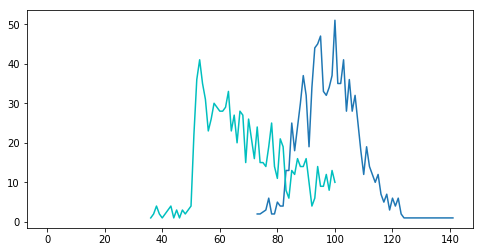

happiness: 98.21% carb utage: 69.53%
happiness: 99.05% carb utage: 69.45%
----Evaluate utility by log 
 (Recommend behavior adjustion from 100 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.49% carb utage: 69.43%


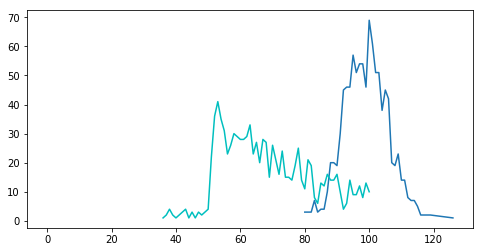

happiness: 98.74% carb utage: 69.53%
happiness: 99.52% carb utage: 69.45%
----Evaluate utility by root 
 (Recommend behavior adjustion from 100 neighbors using features
Importance, Units, Importance_and_Units, respectively)

happiness: 99.13% carb utage: 69.43%


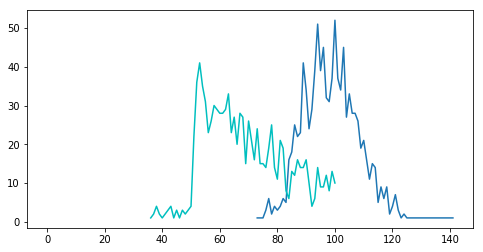

happiness: 98.40% carb utage: 69.53%
happiness: 99.19% carb utage: 69.45%
----Evaluate utility by tanh 
 (Recommend behavior adjustion from 100 neighbors using features
Importance, Units, Importance_and_Units, respectively)



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [56]:
K=[10,20,50,100]
fucs=['linear','softmax','log','root','tanh']
[report(k,fuc) for k in K for fuc in fucs]
#K=[10]
#fucs=['softmax','linear']
#report(10,'softmax')


# The Importance and Time Units 
We scatter the points of each activity of each individual by the importance they value on the activity and time units they spend.

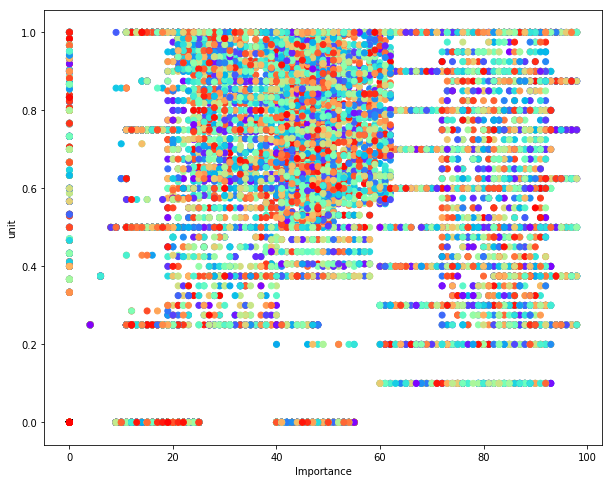

In [46]:
import matplotlib
def Importance_Unit(indivs):

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, 1006)) 
    

    cs = [colors[i] for i in range(len(indivs))]

    xdata = [x for x in indivs[:,0]]
    ydata = [y for y in indivs[:,1]]
    
    
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.scatter(xdata,ydata,color=cs)

    plt.xlabel('Importance')
    plt.ylabel('unit')
    #plt.title()
    
    plt.show()
    

Importance_Unit(norm_users)
    

 # Help Function
* **Clear_text**: Get rid of unnecessary symbols of given input string
* **To_int** : Switch the gien string to int
* **Carb_cnt** : Compute the corresponding carbon footprint on given activity, energy type, and unit individual spent
* **Carb_plot** : Sort and plot the given list of carbon footprint 
* **Norm_units** : Normalize the time units for all users
* **Softmax**: Apply softmax on an given array x
* **To_fuc**: Apply assign fucton on givn array x
* **Happy**: Compute the happiness. We assume the happiness is linear proportional to the importance they value the activities. But according to the margin effect, the happiness will not linear proportail to the time units. So we let users dicide the function they want to apply on the time unit (ex log or root square etc).
* **Adjust_I**: Every user have their value on their daily activities. Applying our recommendation system, we may recommend the user do some activities not in their daily life. In such kind of case, we will update the user's importance list (I) which is 0 (don't know) with the importance list of the candidate neighbor we suggest (cand_I).

In [43]:
def clear_text(string):
    tmp=string.split('_')
    tmp=' '.join(tmp)
    tmp=tmp.split('-')
    tmp=' '.join(tmp)
    tmp=tmp.split('   ')
    tmp=' '.join(tmp)
    return tmp


def to_int(string):
    return 0 if string=='' else abs(int(string))

def carb_cnt(act,eneg,unit):
    eneg=clear_text(eneg)
    #carb_per_unit = carb_map[acts.index(act)][cols.index(eneg)]
    carb_per_unit = max(carb_map[acts.index(act)][2:])
    return 0 if carb_per_unit=='' else float(carb_per_unit)*unit

def carb_plot(carbs,title):
    x=[i for i in range(len(carbs))]
    y=sorted(carbs)
    plt.title(title)
    plt.plot(x,y,color='green')#,tick_label=acts[:,0])
    
def norm_units(indiv):
    norm_users=np.copy(indiv)
    units=[row[1] for row in norm_users]
    norm_units=normalize(units,axis=0,norm='max')
    for i,x in enumerate(norm_units):
        norm_users[i][1]=x
    return norm_users    

from math import log,sqrt 

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum() 
    
def to_fuc(x,fuc):
    if fuc=='log': return log(1+x)
    if fuc=='root': return sqrt(x)
    if fuc=='tanh': return np.tanh(x)
    if fuc=='linear': return float(x)
    if fuc=='softmax': return softmax(x)
    
def Happy(I,fuc,U,i):
    return sum([I[i]*to_fuc(U[i],fuc) for i in range(len(I)) if U[i]>0])
def adjust_I(I,cand_I):
    return [I[i] if I[i]>0 else cand_I[i] for i in range(len(I)) ]